<a href="https://colab.research.google.com/github/suzzini/DS_Project/blob/main/section2_project_finalmodel(%EC%88%98%EC%A0%95%EB%B3%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install -U scikit-learn

In [2]:
import pandas as pd
train_apt=pd.read_csv("seoul_train.csv")
test=pd.read_csv("seoul_test.csv")

train_apt.shape, test.shape

((91364, 13), (3911, 12))

In [3]:
#너무 큰 이상치를 제거하기 위해 가격을 기준으로 데이터를 삭제함
train_apt=train_apt[train_apt['transaction_real_price']<200000]

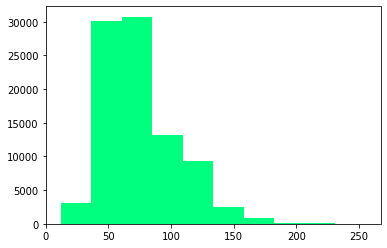

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.hist(train_apt['exclusive_use_area'],color='springgreen')
plt.show()

전용면적의 크기가 너무 다양하기 때문에 1~6까지 구간을 나누어서 바꾸어 처리함

In [5]:
def area(x):
  if x<=50:
    return 1
  elif x<=100:
    return 2
  elif x<=150:
    return 3
  elif x<=200:
    return 4
  elif x<=250:
    return 5
  else :
    return 6

In [6]:
new=[]
for i in train_apt['exclusive_use_area']:
  new.append(area(i))

train_apt['area']=new
train_apt

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,area
0,1092655,1247,서울특별시,사직동,9,광화문풍림스페이스본(9-0),사직동 9 광화문풍림스페이스본(9-0),70.80,2008,201701,1~10,1,67000,2
1,1092656,1247,서울특별시,사직동,9,광화문풍림스페이스본(9-0),사직동 9 광화문풍림스페이스본(9-0),94.51,2008,201701,11~20,8,89300,2
2,1092657,1247,서울특별시,사직동,9,광화문풍림스페이스본(9-0),사직동 9 광화문풍림스페이스본(9-0),160.85,2008,201701,11~20,11,110000,4
3,1092658,1247,서울특별시,사직동,9,광화문풍림스페이스본(9-0),사직동 9 광화문풍림스페이스본(9-0),94.51,2008,201701,21~31,6,86000,2
4,1092659,1247,서울특별시,사직동,9,광화문풍림스페이스본(9-0),사직동 9 광화문풍림스페이스본(9-0),136.40,2008,201701,21~31,3,117000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91359,1196844,996,서울특별시,강일동,717,고덕리엔파크2단지,강일동 717 고덕리엔파크2단지,59.72,2011,201711,11~20,9,53000,2
91360,1196846,682,서울특별시,강일동,674,강일리버파크3단지,강일동 674 강일리버파크3단지,59.87,2009,201711,21~30,12,53000,2
91361,1196847,682,서울특별시,강일동,674,강일리버파크3단지,강일동 674 강일리버파크3단지,84.74,2009,201711,21~30,3,56500,2
91362,1196848,680,서울특별시,강일동,665,강일리버파크1단지,강일동 665 강일리버파크1단지,84.74,2009,201711,21~30,9,55500,2


In [7]:
new=[]
for i in test['exclusive_use_area']:
  new.append(area(i))

test['area']=new
test

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,area
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.550,2002,201711,11~20,2,1
1,1179897,11086,서울특별시,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.540,2004,201707,1~10,10,3
2,1151450,9179,서울특별시,염창동,254-2,이너스내안에,염창동 254-2 이너스내안에,84.910,2004,201711,1~10,13,2
3,1197195,4018,서울특별시,암사동,414-2,롯데캐슬퍼스트,암사동 414-2 롯데캐슬퍼스트,102.340,2008,201712,21~31,9,3
4,1146078,4397,서울특별시,신정동,311,목동신시가지10,신정동 311 목동신시가지10,106.060,1987,201712,11~20,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,1131346,12202,서울특별시,하계동,270,현대,하계동 270 현대,71.680,1988,201712,11~20,8,2
3907,1174640,8965,서울특별시,양재동,15-9,위너스,양재동 15-9 위너스,84.050,2003,201710,11~20,7,2
3908,1175575,3831,서울특별시,반포동,18-1,래미안퍼스티지,반포동 18-1 래미안퍼스티지,84.930,2009,201712,1~10,4,2
3909,1157024,5550,서울특별시,구로동,256-1,삼성래미안,구로동 256-1 삼성래미안,110.188,2004,201712,21~31,23,3


### 거래한 월과 지어진 지 몇년이 되었는지를 나타내는 feature을 새로 생성함

In [8]:
train_apt['transaction_month']=train_apt['transaction_year_month']%100
train_apt['years_since_completion']=2017-train_apt['year_of_completion']+1

In [9]:
test['transaction_month']=test['transaction_year_month']%100
test['years_since_completion']=2017-test['year_of_completion']+1

In [10]:
#필요없는 컬럼 삭제
train_apt=train_apt.drop(['exclusive_use_area','transaction_id','city','jibun','addr_kr','transaction_date','transaction_year_month'],axis=1)

In [11]:
test=test.drop(['exclusive_use_area','transaction_id','city','jibun','addr_kr','transaction_date','transaction_year_month'],axis=1)

## 공원과 관련한 데이터 셋 준비
- 같은 동에 위치한 공원의 개수 세기
- 해당 동에 위치한 공원들의 평균 면적을 계산하여 테이블 생성
- merge 옵션을 통해 기존 테이블에 공원에 관련된 컬럼 추가

In [14]:
park=pd.read_csv('park.csv')
park=park[park['city']=='서울특별시']
park

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
58,서울특별시,서초구,반포동,반 포,근린공원,26092.2,NaN,NaN,NaN,NaN,NaN,1981.0,2018-06-30
59,서울특별시,서초구,양재동,방아다리1,근린공원,2870.8,NaN,NaN,NaN,NaN,NaN,1988.0,2018-06-30
60,서울특별시,서초구,양재동,방아다리2,근린공원,2934.3,NaN,NaN,NaN,NaN,NaN,1988.0,2018-06-30
61,서울특별시,서초구,양재동,양재천,근린공원,19258.0,NaN,NaN,NaN,NaN,NaN,1988.0,2018-06-30
62,서울특별시,서초구,양재동,마 방,근린공원,6546.6,NaN,NaN,NaN,NaN,NaN,1983.0,2018-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,서울특별시,구로구,천왕동,이펜시아어린이공원,어린이공원,1500.0,NaN,조합놀이 1기,NaN,NaN,NaN,2006.0,2019-02-25
1355,서울특별시,구로구,천왕동,개명소공원,소공원,5415.0,NaN,NaN,NaN,NaN,NaN,2006.0,2019-02-25
1356,서울특별시,구로구,천왕동,봉화대근린공원,근린공원,60975.0,NaN,NaN,NaN,NaN,NaN,2006.0,2019-02-25
1357,서울특별시,구로구,항동,푸른수목원,근린공원,100809.0,NaN,NaN,NaN,NaN,NaN,2005.0,2019-02-25


In [15]:
park_df=park.groupby('dong').count().iloc[:,0:1]
park_df

,city
dong,
가락동,13
가산동,3
가양동,14
갈현동,6
강일동,9
...,...
회기동,1
효창동,2
후암동,2


In [16]:
park_df['park_mean_area']=park.groupby('dong').mean().iloc[:,0:1]
park_df=park_df.reset_index()
park_df

,dong,city,park_mean_area
0,가락동,13,7914.030769
1,가산동,3,1216.866667
2,가양동,14,16307.464286
3,갈현동,6,1385.466667
4,강일동,9,23467.344444
...,...,...,...
157,회기동,1,400.000000
158,효창동,2,85901.000000
159,후암동,2,1261.000000
160,휘경동,5,1393.180000


In [17]:
#park에만 있는 dong 삭제하기 위해 dong 찾기
delete_dong_list=list(set(park_df['dong'].unique())-set(train_apt['dong'].unique()))
delete_dong_list

['청파동3가', '원효로3가', '명륜3가', '을지로5가', '능동', '정동', '청룡동']

In [18]:
delete_park_df=park_df[(park_df['dong']=='청룡동') | (park_df['dong']=='을지로5가') | (park_df['dong']=='정동')|(park_df['dong']=='원효로3가')|(park_df['dong']=='청파동3가')|(park_df['dong']=='명륜3가')|(park_df['dong']=='능동')].index
delete_park_df

Int64Index([25, 47, 114, 116, 129, 139, 140], dtype='int64')

In [19]:
#train 데이터를 위해 park에만 있는 관측치 삭제해주기
park_df_for_train=park_df.drop(delete_park_df,axis=0)

In [20]:
train_apt=train_apt.merge(park_df_for_train, on='dong',how='outer')
train_apt.rename(columns={'city':'num_park'},inplace=True)
train_apt

,apartment_id,dong,apt,year_of_completion,floor,transaction_real_price,area,transaction_month,years_since_completion,num_park,park_mean_area
0,1247,사직동,광화문풍림스페이스본(9-0),2008,1,67000,2,1,10,NaN,NaN
1,1247,사직동,광화문풍림스페이스본(9-0),2008,8,89300,2,1,10,NaN,NaN
2,1247,사직동,광화문풍림스페이스본(9-0),2008,11,110000,4,1,10,NaN,NaN
3,1247,사직동,광화문풍림스페이스본(9-0),2008,6,86000,2,1,10,NaN,NaN
4,1247,사직동,광화문풍림스페이스본(9-0),2008,3,117000,3,1,10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
90198,996,강일동,고덕리엔파크2단지,2011,9,53000,2,11,7,9.0,23467.344444
90199,682,강일동,강일리버파크3단지,2009,12,53000,2,11,9,9.0,23467.344444
90200,682,강일동,강일리버파크3단지,2009,3,56500,2,11,9,9.0,23467.344444
90201,680,강일동,강일리버파크1단지,2009,9,55500,2,11,9,9.0,23467.344444


In [21]:
delete_dong_list_test=list(set(park_df['dong'].unique())-set(test['dong'].unique()))
delete_dong_list_test

['영등포동2가',
 '원효로3가',
 '신문로1가',
 '신설동',
 '합동',
 '명륜3가',
 '순화동',
 '충무로5가',
 '능동',
 '정동',
 '청룡동',
 '만리동2가']

In [22]:
delete_park_df_test=park_df[(park_df['dong']=='순화동') | (park_df['dong']=='청룡동') | (park_df['dong']=='충무로5가')|(park_df['dong']=='만리동2가')|(park_df['dong']=='능동')|(park_df['dong']=='신설동')|(park_df['dong']=='신문로1가')|(park_df['dong']=='정동')|(park_df['dong']=='합동')|(park_df['dong']=='명륜3가')|(park_df['dong']=='원효로3가')|(park_df['dong']=='영등포동2가')].index
delete_park_df_test

Int64Index([25, 44, 47, 79, 87, 89, 102, 114, 129, 139, 141, 147], dtype='int64')

In [23]:
park_df_for_test=park_df.drop(delete_park_df_test,axis=0)

In [24]:
test=test.merge(park_df_for_test, on='dong',how='outer')
test.rename(columns={'city':'num_park'},inplace=True)
test

,apartment_id,dong,apt,year_of_completion,floor,area,transaction_month,years_since_completion,num_park,park_mean_area
0,10453,목동,청학,2002,2,1,11,16,NaN,NaN
1,4419,목동,목동효성,2003,4,2,12,15,NaN,NaN
2,4407,목동,목동신시가지6,1986,15,2,12,32,NaN,NaN
3,7911,목동,애드웰(774-10),2004,5,2,4,14,NaN,NaN
4,1691,목동,금호아파트(768),1995,1,2,12,23,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3906,9072,당산동6가,유탑유블레스,2012,6,1,7,6,NaN,NaN
3907,7593,노고산동,신촌포스빌,2004,3,1,12,14,NaN,NaN
3908,7754,명륜2가,아남1,1995,18,2,12,23,NaN,NaN
3909,7756,명륜2가,아남3,1999,6,1,11,19,NaN,NaN


In [25]:
train_apt=train_apt.fillna(0)
test=test.fillna(0)

In [26]:
area_df_train=pd.DataFrame(train_apt.groupby(['area']).mean().iloc[:,3])
area_df_train=area_df_train.reset_index()
area_df_train

,area,transaction_real_price
0,1,29654.240226
1,2,56393.287913
2,3,86037.584589
3,4,124306.354060
4,5,144953.891667
5,6,170000.000000


In [27]:
train_apt=train_apt.merge(area_df_train, on='area',how='outer')
train_apt=train_apt.rename(columns={'transaction_real_price_y':'mean_price_area','transaction_real_price_x':'transaction_real_price'})
train_apt

,apartment_id,dong,apt,year_of_completion,floor,transaction_real_price,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
0,1247,사직동,광화문풍림스페이스본(9-0),2008,1,67000,2,1,10,0.0,0.000000,56393.287913
1,1247,사직동,광화문풍림스페이스본(9-0),2008,8,89300,2,1,10,0.0,0.000000,56393.287913
2,1247,사직동,광화문풍림스페이스본(9-0),2008,6,86000,2,1,10,0.0,0.000000,56393.287913
3,1247,사직동,광화문풍림스페이스본(9-0),2008,8,82500,2,2,10,0.0,0.000000,56393.287913
4,1247,사직동,광화문풍림스페이스본(9-0),2008,3,87900,2,3,10,0.0,0.000000,56393.287913
...,...,...,...,...,...,...,...,...,...,...,...,...
90198,3614,천호동,두산위브센티움,2004,4,16550,1,10,14,0.0,0.000000,29654.240226
90199,11526,천호동,한신,1991,12,27000,1,10,27,0.0,0.000000,29654.240226
90200,1712,천호동,금호,1987,10,22500,1,10,31,0.0,0.000000,29654.240226
90201,1712,천호동,금호,1987,4,22500,1,11,31,0.0,0.000000,29654.240226


In [28]:
#결측치는 공원이 없다는 것을 의미하므로 0으로 채워주기
train_apt=train_apt.fillna(0)
test=test.fillna(0)

,apartment_id,dong,apt,year_of_completion,floor,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
0,10453,목동,청학,2002,2,1,11,16,0.0,0.000000,29654.240226
1,4405,목동,목동신시가지4,1986,16,1,12,32,0.0,0.000000,29654.240226
2,4402,목동,목동신시가지1,1985,11,1,12,33,0.0,0.000000,29654.240226
3,6075,목동,상진지오밸리나동,2006,7,1,10,12,0.0,0.000000,29654.240226
4,4407,목동,목동신시가지6,1986,13,1,12,32,0.0,0.000000,29654.240226
...,...,...,...,...,...,...,...,...,...,...,...
3906,6068,장충동1가,상지리츠빌장충동카일룸,2008,5,5,2,10,0.0,0.000000,144953.891667
3907,10856,방배동,태화빌라(733),1994,4,6,8,24,18.0,18255.483333,170000.000000
3908,10283,청담동,청담8차상지리츠빌,2003,4,6,12,15,4.0,20008.725000,170000.000000
3909,10900,서초동,트라움하우스2,1996,6,6,7,22,15.0,38061.886667,170000.000000


In [30]:
train_apt.corr()

,apartment_id,year_of_completion,floor,transaction_real_price,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
apartment_id,1.000000,-0.111044,-0.014861,-0.036094,-0.025349,-0.011113,0.111044,-0.039314,0.048057,-0.024056
year_of_completion,-0.111044,1.000000,0.212779,0.032338,0.119281,0.017986,-1.000000,0.047651,-0.192848,0.110935
floor,-0.014861,0.212779,1.000000,0.135005,0.118617,0.026996,-0.212779,-0.037511,-0.064059,0.118673
transaction_real_price,-0.036094,0.032338,0.135005,1.000000,0.523020,0.108078,-0.032338,0.269789,-0.206908,0.524678
area,-0.025349,0.119281,0.118617,0.523020,1.000000,0.024486,-0.119281,0.043822,-0.182554,0.996841
transaction_month,-0.011113,0.017986,0.026996,0.108078,0.024486,1.000000,-0.017986,-0.001814,-0.028923,0.023137
years_since_completion,0.111044,-1.000000,-0.212779,-0.032338,-0.119281,-0.017986,1.000000,-0.047651,0.192848,-0.110935
num_park,-0.039314,0.047651,-0.037511,0.269789,0.043822,-0.001814,-0.047651,1.000000,-0.179599,0.048992
park_mean_area,0.048057,-0.192848,-0.064059,-0.206908,-0.182554,-0.028923,0.192848,-0.179599,1.000000,-0.173709
mean_price_area,-0.024056,0.110935,0.118673,0.524678,0.996841,0.023137,-0.110935,0.048992,-0.173709,1.000000


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44400 missing from current font.
  w /= 64.0  # convert from subpixels
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  w /= 64.0  # convert from subpixels
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  w /= 64.0  # convert from subpixels
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  w /= 64.0  # convert from subpixels
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44257 missing from current font.
  w /= 64.0  # convert from subpixels
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  w /=

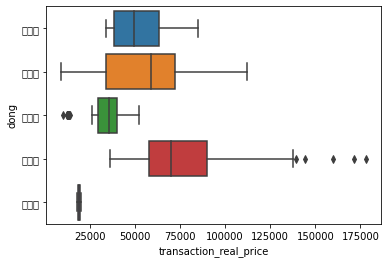

In [37]:
test1=train_apt[(train_apt['dong']=='성북동')|(train_apt['dong']=='수서동')|(train_apt['dong']=='가산동')|(train_apt['dong']=='화곡동')|(train_apt['dong']=='군자동')]

sns.boxplot(x='transaction_real_price',y='dong',data=test1);

## 최종모델

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_apt, test_size=0.2, random_state=2)

In [ ]:
train.shape, val.shape, test.shape

((72162, 12), (18041, 12), (3911, 11))

In [ ]:
target = 'transaction_real_price'

features = train_apt.columns.drop([target,'apt','apartment_id']) #필요없는 컬럼 지우기
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]

X_test = test[features]

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.9318550137387037


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

y_pred = pipe_ord.predict(X_val)

print('MAE : ',mean_absolute_error(y_val, y_pred))
MSE=mean_absolute_error(y_val, y_pred)
print('MSE : ',mean_squared_error(y_val, y_pred))
print('R^2 : ', r2_score(y_val, y_pred))
print('RMSE : ',np.sqrt(MSE))

MAE :  5522.385973261896
MSE :  71326120.01211232
R^2 :  0.9318550137387037
RMSE :  74.31275780955714


## linear regression

In [ ]:
target = 'transaction_real_price'

features = train_apt.columns.drop([target,'apt','apartment_id']) 
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]
X_test = test[features]

from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R^2', linear.score(X_val, y_val))

R^2 0.809766605100143


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
coefficients = linear.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

dong                         0.833775
year_of_completion          25.647630
floor                      293.573476
area                       566.584619
transaction_month         1174.078787
years_since_completion     -25.647630
num_park                   133.413170
park_mean_area               0.001021
mean_price_area              0.626663
dtype: float64

## Ridge regression

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from category_encoders import TargetEncoder
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

alphas = [0.01, 0.05, 0.1, 0.2,0.5,0.7,1.0, 10.0]

encoder = TargetEncoder()

X_train = encoder.fit_transform(X_train,y_train) #sckit : fit을 하고 transform
X_val = encoder.transform(X_val) #그러한 정보를 사용해서 다른 정보를 넣엇을 때, x_train 처럼 바꿔줌.

ridge = RidgeCV(alphas=alphas, normalize=True, cv=5) #데이터를 3등분, 각 알파마다 세개의 모델을 만듬 
#score은 평균값
ridge.fit(X_train, y_train)
print("alpha: ", ridge.alpha_)
print("best score: ", ridge.best_score_)
print('검증 정확도: ', ridge.score(X_val, y_val))
#훈련데이터와 트레이닝 테이터를 나누는 방법을/ 모든 데이터가 다 트레이닝 데이터가 될 수 있게 :cross validation

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


alpha:  0.01
best score:  0.8023979433824027
검증 정확도:  0.8013155110015288


In [ ]:
y_pred = ridge.predict(X_val)

print('MAE : ',mean_absolute_error(y_val, y_pred))
MSE=mean_absolute_error(y_val, y_pred)
print('MSE : ',mean_squared_error(y_val, y_pred))
print('R^2 : ', r2_score(y_val, y_pred))
print('RMSE : ',np.sqrt(MSE))

MAE :  10240.169467172935
MSE :  207959447.70626453
R^2 :  0.8013155110015288
RMSE :  101.19372246919734


## tree 모델

In [ ]:
target = 'transaction_real_price'

features = train_apt.columns.drop([target,'apt','apartment_id','year_of_completion']) 
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]
X_test = test[features]

from sklearn.tree import DecisionTreeRegressor

tree = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeRegressor(random_state=2) #best 파라미터를 쓰면 모든 경우의 수를 계산해게 됨
    #entropy 디폴트는 지니 
)

tree.fit(X_train, y_train)
print('훈련 정확도: ', tree.score(X_train, y_train))
print('검증 정확도: ', tree.score(X_val, y_val))

훈련 정확도:  0.9915965704527658
검증 정확도:  0.8983009390917478


In [ ]:
y_pred = tree.predict(X_val)

print('MAE : ',mean_absolute_error(y_val, y_pred))
MSE=mean_absolute_error(y_val, y_pred)
print('MSE : ',mean_squared_error(y_val, y_pred))
print('R^2 : ', r2_score(y_val, y_pred))
print('RMSE : ',np.sqrt(MSE))

MAE :  6456.314529736981
MSE :  106526975.06460732
R^2 :  0.8982241112932768
RMSE :  80.35119494902973


In [ ]:
import seaborn as sns

palette = sns.color_palette("bright")

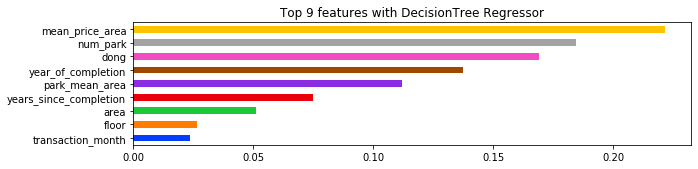

In [ ]:
enc = tree.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_train).columns

model_dt = tree.named_steps['decisiontreeregressor']
importances = pd.Series(model_dt.feature_importances_, encoded_columns)
n=9
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with DecisionTree Regressor')
importances.sort_values().plot.barh(color=palette);

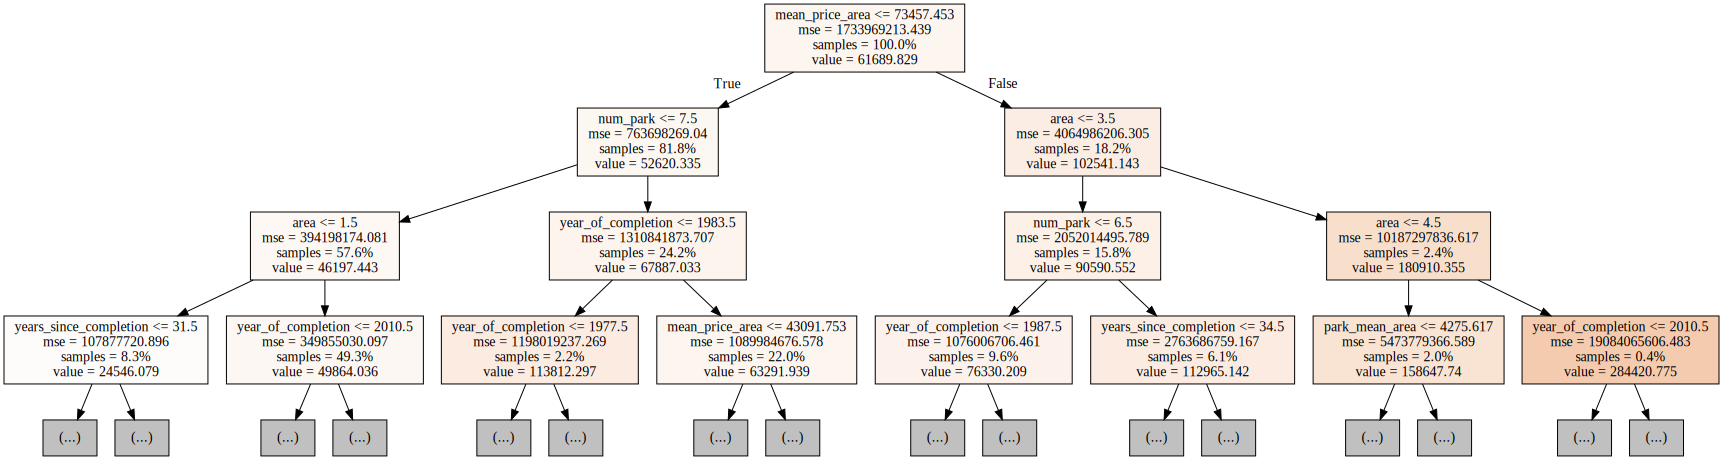

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model_dt
                          , max_depth=3 #3층까지만
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

## randomforest

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

target = 'transaction_real_price'

features = train_apt.columns.drop([target,'apt','apartment_id']) 
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]
X_test = test[features]


pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.9318550137387037


In [ ]:
y_pred = pipe_ord.predict(X_val)

print('MAE : ',mean_absolute_error(y_val, y_pred))
MSE=mean_absolute_error(y_val, y_pred)
print('MSE : ',mean_squared_error(y_val, y_pred))
print('R^2 : ', r2_score(y_val, y_pred))
print('RMSE : ',np.sqrt(MSE))

MAE :  5522.385973261896
MSE :  71326120.01211232
R^2 :  0.9318550137387037
RMSE :  74.31275780955714


## shap

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

target = 'transaction_real_price'


features = train_apt.columns.drop([target,'apt','apartment_id','dong','year_of_completion']) 
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]
X_test = test[features]

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)


# XGBoost 분류기를 학습시킵니다. 클래스 비율을 맞추기 위해 scale_pos_weight= #Charged Off / # Fully Paid
model = RandomForestRegressor(random_state=10, n_jobs=-1, oob_score=True)
model.fit(X_train_processed, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=10)

In [ ]:
print('검증 정확도', model.score(X_val_processed, y_val))

검증 정확도 0.8773886689975735


In [ ]:
row = X_val.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row


,floor,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
85450,5,1,8,16,0.0,0.0,29654.240226


In [ ]:
y_val.iloc[[1]] # 2번째 데이터를 사용했습니다

85801    24000
Name: transaction_real_price, dtype: int64

In [ ]:
model.predict(row)

array([25143.05660173])

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
df = pd.DataFrame(
        data=[[	5,	1,	8,	1,	0.0	,0.0,	29654.240226]], 
        columns=[	'floor',	'area',	'transaction_month',	'years_since_completion',	'num_park',	'park_mean_area',	'mean_price_area']
    )
df

,floor,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
0,5,1,8,1,0.0,0.0,29654.240226


In [ ]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(df)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=df
)

In [ ]:
df = pd.DataFrame(
        data=[[	5,	5,	8,	1,	0.0	,0.0,	29654.240226]], 
        columns=[	'floor',	'area',	'transaction_month',	'years_since_completion',	'num_park',	'park_mean_area',	'mean_price_area']
    )
df

,floor,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
0,5,5,8,1,0.0,0.0,29654.240226


In [ ]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(df)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=df
)

In [ ]:
df = pd.DataFrame(
        data=[[	5,	5,	8,	16,	0.0	,0.0,	29654.240226]], 
        columns=[	'floor',	'area',	'transaction_month',	'years_since_completion',	'num_park',	'park_mean_area',	'mean_price_area']
    )
df

,floor,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
0,5,5,8,16,0.0,0.0,29654.240226


In [ ]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(df)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=df
)

In [ ]:
 X_val[X_val['area']==5].index

Int64Index([79191, 79209, 79183, 79131, 79139, 79220, 79148, 79158, 79226,
            79159, 79160, 79113, 79204, 79132, 79109, 79167, 79211, 79175,
            79223, 79112, 79135, 79154, 79123],
           dtype='int64')

In [ ]:
 row=X_val.loc[[79209]]
 row

,year_of_completion,floor,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
79209,2004,12,5,9,14,15.0,38061.886667,144953.891667


In [ ]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:100])

In [ ]:
random_x_test=X_test.sample(frac=1,random_state=1)
random_x_train=X_train.sample(frac=1,random_state=1)

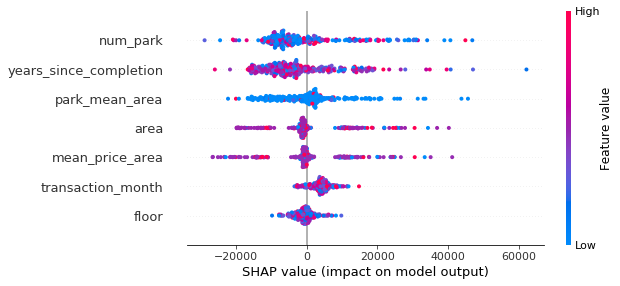

In [ ]:
shap_values = explainer.shap_values(random_x_test.iloc[:300])
shap.summary_plot(shap_values, random_x_train.iloc[:300])

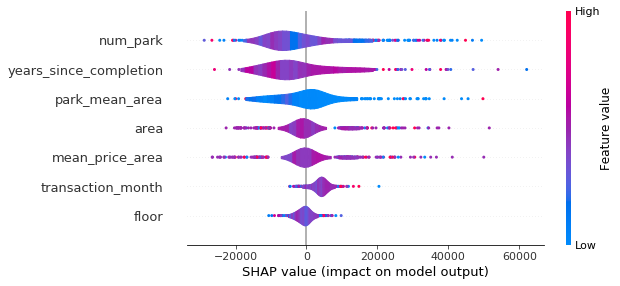

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(random_x_test.iloc[:500])
shap.summary_plot(shap_values, random_x_train.iloc[:500], plot_type="violin")

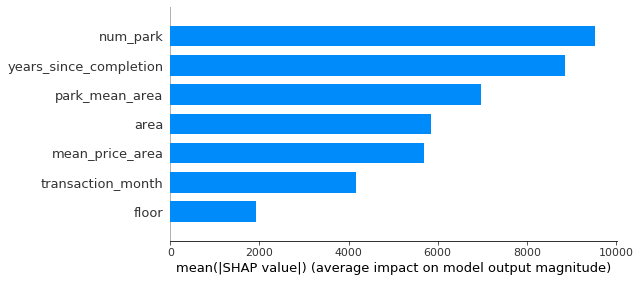

In [ ]:
shap.summary_plot(shap_values, random_x_train.iloc[:500], plot_type="bar")

## LIGHTGBM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

target = 'transaction_real_price'

features = train_apt.columns.drop([target,'apt','apartment_id']) 
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]
X_test = test[features]


random = make_pipeline(
    TargetEncoder(),
    #OrdinalEncoder(),
    #SimpleImputer(), 
    LGBMRegressor(random_state=10, n_jobs=-1,class_weight='balanced')
)
# 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
dists = {
          'lgbmregressor__max_depth' : range(5, 30,5),
           'lgbmregressor__min_child_samples' : [5,10,20],
          'lgbmregressor__n_estimators' : [10,100,1000],
         'lgbmregressor__boosting_type':['gdbt', 'rf','dart','goss']
}

clf = RandomizedSearchCV(
    random, 
    param_distributions=dists, 
    n_iter=30, #50번 반복, 3회는 전체 150번의 학습/ 이 두 수치에 유의해야함
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.92649069        nan 0.92700577
 0.90115592        nan        nan 0.86212727        nan 0.92003815
 0.86502066 0.91610005 0.86494646        nan        nan 0.9183813
 0.69509828        nan 0.91660968 0.69770443        nan 0.90807058
        nan 0.90117709 0.91852465 0.69662326 0.69770443 0.69777985]
  category=UserWarning
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
print('검증 정확도', clf.score(X_val, y_val))

검증 정확도 0.9321600328986489


In [ ]:
clf.best_params_

{'lgbmregressor__boosting_type': 'goss',
 'lgbmregressor__max_depth': 20,
 'lgbmregressor__min_child_samples': 5,
 'lgbmregressor__n_estimators': 1000}

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


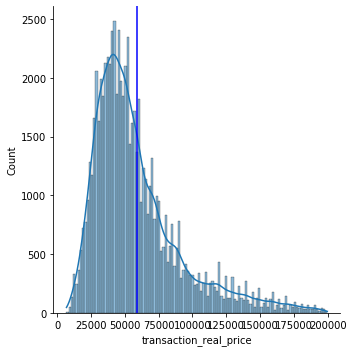

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## SalePrice의 확률밀도함수를 그려보겠습니다
sns.displot(train['transaction_real_price'], kde=True)

## 평균과, 중간값으로 수직선을 그려보겠습니다.

plt.axvline(train['transaction_real_price'].mean(), color='blue')


#plt.axvline(train['transaction_real_price'].median(), color='red');

In [ ]:
baseline=train['transaction_real_price'].mean()
baseline

59046.37151132175

In [ ]:
baseline=[baseline] * len(y_val)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error


print('MAE : ',mean_absolute_error(y_val, baseline))
MSE=mean_absolute_error(y_val, baseline)
print('MSE : ',mean_squared_error(y_val, baseline))
print('R^2 : ', r2_score(y_val, baseline))
print('RMSE : ',np.sqrt(MSE))

MAE :  24108.503826373017
MSE :  1047464790.1279479
R^2 :  -0.0007480249919562532
RMSE :  155.2691335274755


In [ ]:
train['transaction_real_price'].describe()

count     73091.000000
mean      61689.829090
std       41641.240822
min        7000.000000
25%       37000.000000
50%       50700.000000
75%       72300.000000
max      780000.000000
Name: transaction_real_price, dtype: float64

In [ ]:
train.shape, a.shape

((73091, 12), (72133, 12))

In [ ]:
sns.displot(train['area'], kde=True)

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


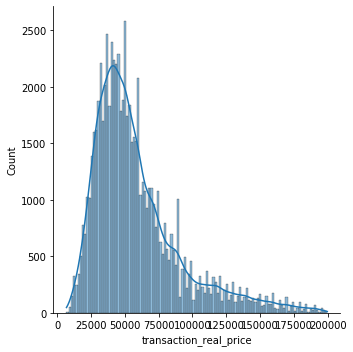

In [ ]:
a=train[train['transaction_real_price']<200000]
sns.displot(a['transaction_real_price'], kde=True)

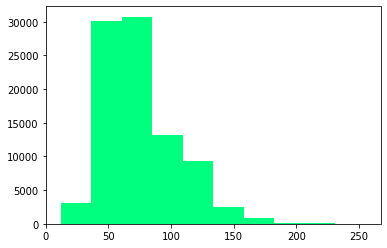

In [ ]:
plt.hist(forarea['exclusive_use_area'],color='springgreen')
plt.show()


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

target = 'transaction_real_price'

features = train_apt.columns.drop([target,'apt','apartment_id','dong']) 
X_train = train[features]
y_train = train[target]
X_val= val[features]
y_val = val[target]
X_test = test[features]


pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler(),
    RandomForestRegressor(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.877426473670935


In [ ]:
standardScaler = StandardScaler()
print(standardScaler.fit(X_train))

standardScaler.transform(y_train)

StandardScaler()


ValueError: ignored

In [ ]:
_scale=train
_scale_val=val

In [ ]:
_scale['transaction_real_price']=_scale['transaction_real_price']*10000
_scale_val['transaction_real_price']=_scale_val['transaction_real_price']*10000
_scale_val


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,apartment_id,dong,apt,year_of_completion,floor,transaction_real_price,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
72346,4152,마곡동,마곡엠밸리2단지,2014,14,920000000,3,10,4,3.0,1.687443e+05,86037.584589
85450,10453,목동,청학,2002,5,360000000,1,8,16,0.0,0.000000e+00,29654.240226
30097,4397,신정동,목동신시가지10,1988,10,750000000,2,4,30,1.0,3.353000e+03,56393.287913
83329,5947,상계동,상계주공11(고층),1988,13,320000000,1,6,30,1.0,6.692795e+06,29654.240226
65982,10464,이태원동,청화1,1982,5,1020000000,3,9,36,2.0,1.149000e+03,86037.584589
...,...,...,...,...,...,...,...,...,...,...,...,...
20948,11254,하계동,학여울청구,1999,2,458000000,2,7,19,0.0,0.000000e+00,56393.287913
79631,9549,전농동,전농우성,1992,13,244000000,1,3,26,4.0,6.849268e+04,29654.240226
77659,2874,신천동,더샵스타리버,2006,24,990000000,3,9,12,9.0,3.680903e+04,86037.584589
22365,5952,상계동,상계주공16(고층),1988,10,407000000,2,7,30,1.0,6.692795e+06,56393.287913


In [ ]:
_scale

28037    850000000
40098    270000000
40987    365000000
3372     882000000
88233    520000000
           ...    
84434    213000000
31019    550000000
44566    670000000
72173    860000000
89256    500000000
Name: transaction_real_price, Length: 72162, dtype: int64

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

target = 'transaction_real_price'

features = train_apt.columns.drop([target,'apt','apartment_id']) 
X_train = _scale[features]
y_train = _scale[target]
X_val= _scale_val[features]
y_val = _scale_val[target]
#X_test = test[features]



In [ ]:
X_train

,dong,year_of_completion,floor,area,transaction_month,years_since_completion,num_park,park_mean_area,mean_price_area
28037,아현동,2014,2,2,4,4,0.0,0.000000e+00,56393.287913
40098,오류동,1998,10,2,7,20,4.0,3.797155e+05,56393.287913
40987,시흥동,1999,19,2,4,19,3.0,8.726667e+03,56393.287913
3372,행당동,2014,26,2,9,4,3.0,2.522967e+03,56393.287913
88233,잠원동,1996,3,1,6,22,11.0,2.670655e+03,29654.240226
...,...,...,...,...,...,...,...,...,...
84434,중계동,1992,7,1,6,26,1.0,5.334267e+06,29654.240226
31019,신정동,1995,11,2,11,23,1.0,3.353000e+03,56393.287913
44566,상도동,2004,15,2,5,14,13.0,2.848295e+04,56393.287913
72173,화곡동,2008,15,3,9,10,31.0,4.549096e+04,86037.584589


In [ ]:

pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=10, n_jobs=-1, oob_score=True)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

검증 정확도 0.9319641721471134
